In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import nltk

In [ ]:
tf.debugging.set_log_device_placement(True)


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and memory growth is set.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Running on CPU.")





GPU is available and memory growth is set.


In [ ]:
print("Downloading stopwords...")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and memory growth is set.")
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available and memory growth is set.


In [ ]:
print("Loading training and testing datasets...")
train_df = pd.read_csv('/train.csv')
test_df = pd.read_csv('/test.csv')

Loading training and testing datasets...


In [ ]:
def eda(data, title='EDA'):
    plt.figure(figsize=(12, 6))
    sns.countplot(y='category', data=data, order=data['category'].value_counts().index)
    plt.title(f'{title}: Count of each Sub-Category')
    plt.xlabel('Count')
    plt.ylabel('Sub-Category')
    plt.show()

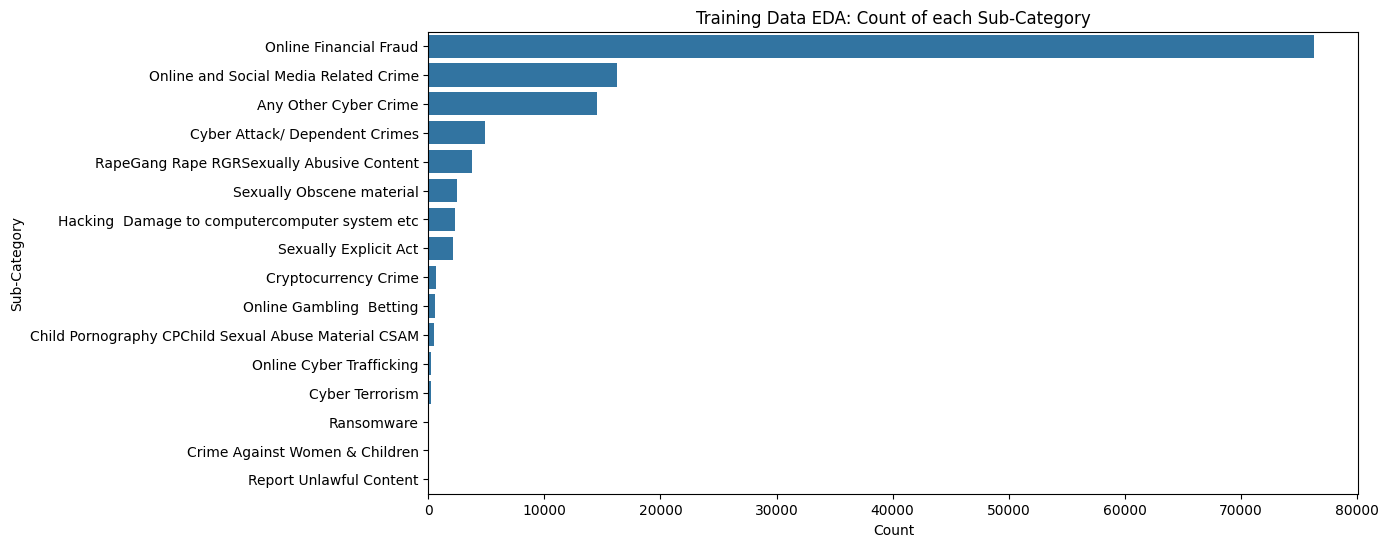

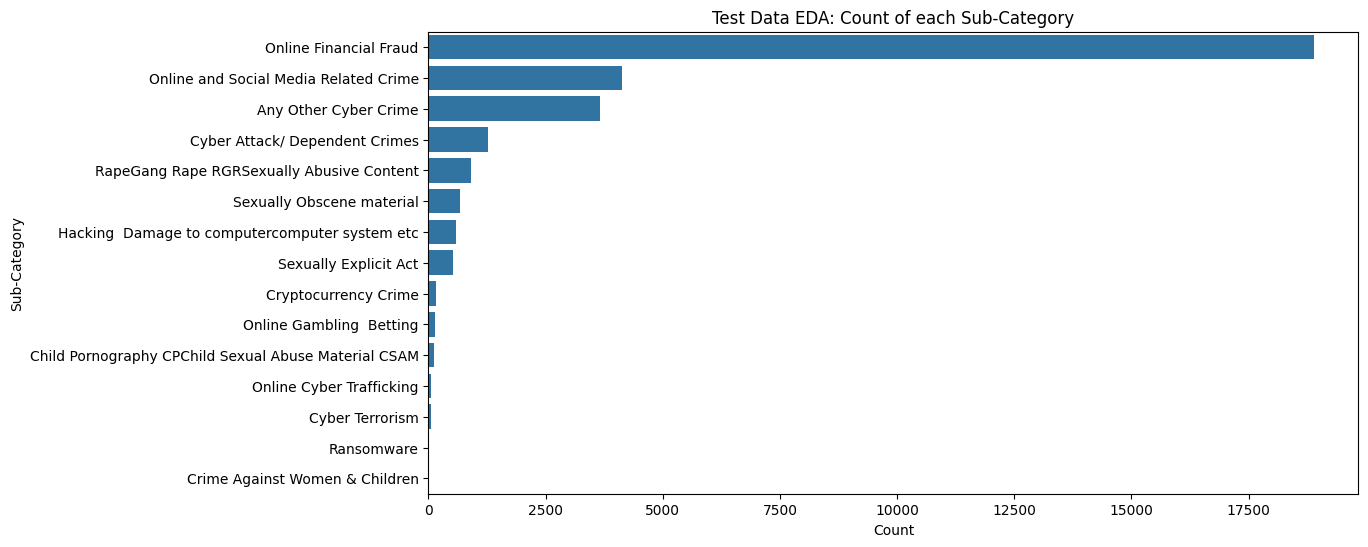

In [ ]:
eda(train_df, title='Training Data EDA')
eda(test_df, title='Test Data EDA')

In [ ]:
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        print(text)
        return text


In [ ]:
print("Applying text preprocessing to training and testing data...")
train_df['crimeaditionalinfo'] = train_df['crimeaditionalinfo'].apply(preprocess_text)
test_df['crimeaditionalinfo'] = test_df['crimeaditionalinfo'].apply(preprocess_text)

Streaming output truncated to the last 5000 lines.
unauthorized transaction in victim account victim dint got sms and phone calls amount lost rs
respected sir a very serious matter i want to inform you few person running or involve in some very shamefull activities by using few women at many places of kolkata gariahat ballygunge ruby hospital behind area kasba anandapur quest mall metropolis mall area acropolismall area park circus forum mall elgin rd parkstreet maidan area esplanade garia jadavpur behalasakherbazar joka bansdroni rabindrasadanexide area haridevpur triangular park lake mall area rashbehari area tollygunge thakurpukur bbd bag dalhousie area and saltlake their name subhro saha amlan datta izaz ahmed anirban they officially work in a insurance office hdfclife a hindustanpark ab gariahat shopping mall st floor beside of reliance trend building near gariahat more but outside at several places they involve in some shamefull activities last years sir a person subhro saha forc

In [ ]:
print("Initializing stop words and stemmer...")
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

Initializing stop words and stemmer...


In [ ]:
def clean_and_stem(text):
    if text is None:  # Check for None values
        return ''
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [ ]:
print("Applying cleaning and stemming to training and testing data...")
train_df['crimeaditionalinfo'] = train_df['crimeaditionalinfo'].apply(clean_and_stem)
test_df['crimeaditionalinfo'] = test_df['crimeaditionalinfo'].apply(clean_and_stem)

Applying cleaning and stemming to training and testing data...


In [ ]:
print("Encoding categorical labels...")
le = LabelEncoder()
train_df['category'] = le.fit_transform(train_df['category'])
test_df['category'] = le.transform(test_df['category'])

Encoding categorical labels...


In [ ]:
MAX_LEN = 100
BATCH_SIZE = 32
EPOCHS = 5
print(f"Model parameters set: MAX_LEN={MAX_LEN}, BATCH_SIZE={BATCH_SIZE}, EPOCHS={EPOCHS}")


Model parameters set: MAX_LEN=100, BATCH_SIZE=32, EPOCHS=5


In [ ]:
from transformers import DistilBertTokenizer

# Use the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
train_encodings = tokenizer(list(train_df['crimeaditionalinfo']), truncation=True, padding=True, max_length=MAX_LEN)
test_encodings = tokenizer(list(test_df['crimeaditionalinfo']), truncation=True, padding=True, max_length=MAX_LEN)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_df['category'].values
)).shuffle(1000).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_df['category'].values
)).batch(BATCH_SIZE)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _Eage

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Lambda
from tensorflow.keras.models import Model
from transformers import TFDistilBertModel

def create_hybrid_model():
    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')

    # Load pre-trained DistilBERT model
    distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

    # Use Lambda to wrap the DistilBERT model
    def distilbert_layer(x):
        return distilbert_model(input_ids=x[0], attention_mask=x[1]).last_hidden_state

    distilbert_output = Lambda(distilbert_layer, output_shape=(MAX_LEN, distilbert_model.config.hidden_size))([input_ids, attention_mask])

    # Extract the [CLS] token equivalent (first token) for classification
    x = distilbert_output[:, 0, :]  # Use only the first token's representation
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(len(le.classes_), activation='softmax')(x)

    model = Model(inputs=[input_ids, attention_mask], outputs=x)
    return model


In [ ]:
model = create_hybrid_model()

print("Compiling the model...")
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executin

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device

In [ ]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=EPOCHS)

Streaming output truncated to the last 5000 lines.
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
3334/3904 ━━━━━━━━━━━━━━━━━━━━ 55s 97ms/step - accuracy: 0.6410 - loss: 1.1947Executing op __inference_one_step_on_iterator_9862 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
3335/3904 ━━━━━━━━━━━━━━━━━━━━ 55s 97ms/step - accuracy: 0.6410 - loss: 1.1947Execut

In [ ]:
print("Evaluating the model...")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Streaming output truncated to the last 5000 lines.
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
264/976 ━━━━━━━━━━━━━━━━━━━━ 1:03 90ms/step - accuracy: 0.6243 - loss: 1.2056Executing op __inference_one_step_on_iterator_66464 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
265/976 ━━━━━━━━━━━━━━━━━━━━ 1:03 90ms/step - accuracy: 0.6244 - loss: 1.2055Executing op __inference_one_step_on_iterator_66464 in device /job:localhost/replica:0/

In [ ]:
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

Streaming output truncated to the last 5000 lines.
Executing op __inference_one_step_on_data_distributed_309971 in device /job:localhost/replica:0/task:0/device:GPU:0
922/976 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/stepExecuting op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_one_step_on_data_distributed_309971 in device /job:localhost/replica:0/task:0/device:GPU:0
923/976 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/stepExecuting op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_one_step_on_data_distributed_309971 in device /job:localhost/replica:0/task:0/device:GPU:0
924/976 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/stepExecuting op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_one_step_on_data_distributed_309971 in device /job:localhost/replica:0/task:0/device:GPU:0
925/976 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/stepExecuting op IteratorGetNext in device /job:localhost/replica:0/task:

In [32]:
print("Classification Report:")
print(classification_report(
    test_df['category'],
    predicted_labels,
    labels=test_df['category'].unique(),
    target_names=le.classes_
))



Classification Report:
                                                      precision    recall  f1-score   support

                               Any Other Cyber Crime       0.93      0.90      0.92       912
Child Pornography CPChild Sexual Abuse Material CSAM       0.63      0.98      0.77     18896
                      Crime Against Women & Children       0.51      0.44      0.47      1261
                                Cryptocurrency Crime       0.00      0.00      0.00      3670
                      Cyber Attack/ Dependent Crimes       0.00      0.00      0.00       592
                                     Cyber Terrorism       0.00      0.00      0.00       535
      Hacking  Damage to computercomputer system etc       0.00      0.00      0.00       666
                            Online Cyber Trafficking       0.00      0.00      0.00      4139
                              Online Financial Fraud       0.00      0.00      0.00       123
                            Online G

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2642: UserWarning: labels size, 15, does not match size of target_names, 16
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

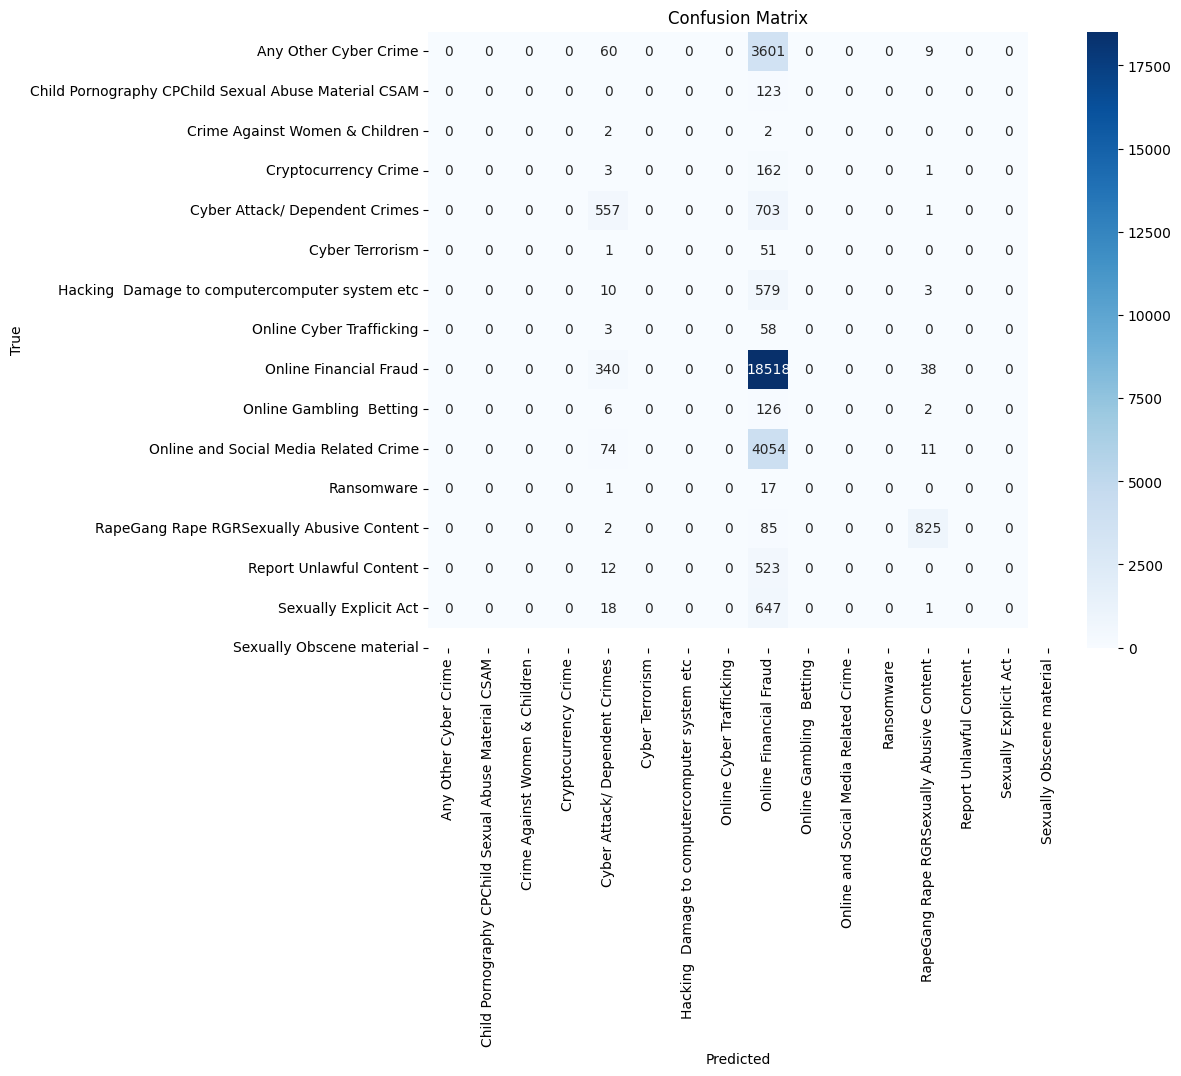

In [33]:
conf_matrix = confusion_matrix(test_df['category'], predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

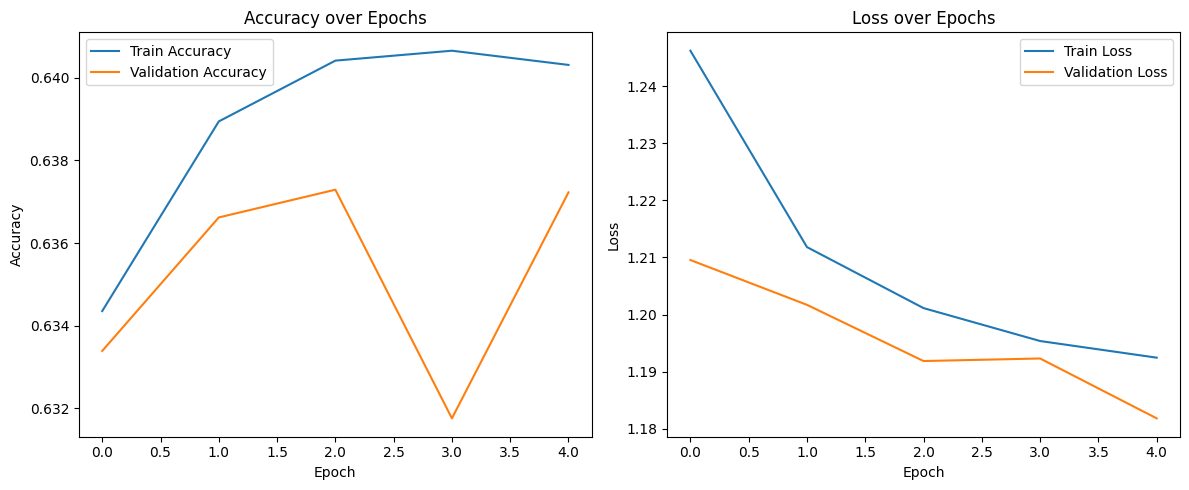

In [34]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()